
# Mode collapse of GAN (Gaussian example)




## Data generation

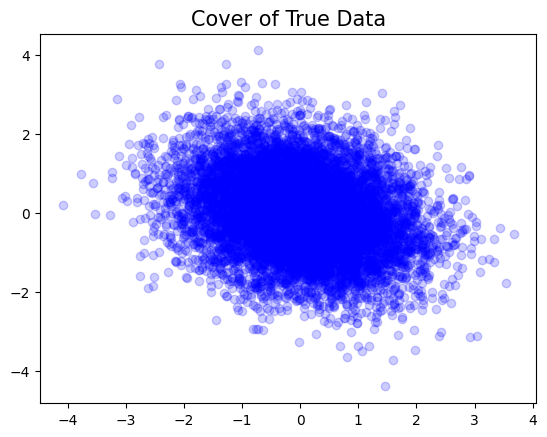

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

## Set seed
np.random.seed(1233)
torch.manual_seed(1233)

## Data generation

x_dim = 2
N = 10000
true_z_dim = 2

### generate synthetic data

Xs = []
for _ in range(1):
    cluster_mean = np.random.randn(true_z_dim) * 1# to make them more spread
    A = np.random.randn(x_dim,true_z_dim) * 1
    X = np.dot(np.random.randn(int(N / 1), true_z_dim)*1 + cluster_mean, A.T)
    Xs.append(X)
X_raw = np.concatenate(Xs)
X = (X_raw - X_raw.mean(0)) / (X_raw.std(0))

X=torch.from_numpy(X).float()

### visualization of the true data

import matplotlib
x = X[:, 0]
y = X[:, 1]
matplotlib.pyplot.scatter(x, y,color='blue', alpha=0.2)
matplotlib.pyplot.title("Cover of True Data",fontsize=15)
matplotlib.pyplot.show()


## Train GAN

In [3]:
### NN structures

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim, output_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        #self.sig=nn.Sigmoid()

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        #out= self.sig(out)
        return out

### Setting

nz=10
batch_size = 64

J_g=1  # Number of generators
J_d=1  # Number of discriminators

G=[None]*J_g
D=[None]*J_d

noise_G=[None]*J_g
noise_D=[None]*J_d

G_optimizer=[None]*J_g
D_optimizer=[None]*J_d


for i in range(J_g):
    G[i]=FeedforwardNeuralNetModel(nz,1000, x_dim).cuda()
    G_optimizer[i]=torch.optim.Adam(G[i].parameters(),betas=(0.5,0.999),lr=2e-4)

for i in range(J_d):
    D[i]=FeedforwardNeuralNetModel(x_dim,1000, 1).cuda()
    D_optimizer[i]=torch.optim.Adam(D[i].parameters(),betas=(0.5,0.999),lr=2e-5)



### Check discriminator outputs

Dis=torch.zeros(3001)
Gen=torch.zeros(3001)
mean_sample=128



loss_criteria=nn.BCEWithLogitsLoss()

real=torch.ones(batch_size).cuda()
fake=torch.zeros(batch_size).cuda()

js=0
sig=nn.Sigmoid()

fake_merge=[]

for iter in range(30001):

    # Train Generator
    for i in range(J_g):
        noise_G[i]=2*torch.rand(batch_size,nz).cuda()-1


    for j in range(J_g):

        G_loss=0

        Gen_Dis=D[0](G[j](noise_G[j])).view(batch_size).requires_grad_()
        G_loss+=loss_criteria(Gen_Dis,real)


        G_optimizer[j].zero_grad()

        G_loss.backward()
        G_optimizer[j].step()



    for i in range(J_d):
        noise_D[i]=2*torch.rand(batch_size,nz).cuda()-1

    for j in range(J_d):

        D_loss=0

        perm = torch.randperm(N)
        idx=perm[:batch_size]
        X_batch=X[idx,].requires_grad_().cuda()


        D_loss+=loss_criteria(D[j](X_batch).view(batch_size),real)+loss_criteria(D[j](G[j](noise_D[j])).view(-1),fake)


        D_optimizer[j].zero_grad()

        D_loss.backward()
        D_optimizer[j].step()


    if (iter+1)%10==1:
      with torch.no_grad():
        perm = torch.randperm(N)
        idx=perm[:mean_sample]
        X_batch=X[idx,].requires_grad_().cuda()
        mean=0
        for i in range(J_g):
          mean+=torch.mean(sig(D[0](G[i](2*torch.rand(mean_sample,nz).cuda()-1)).view(-1)))
        Gen[js]=mean/J_g
        Dis[js]=torch.mean(sig(D[0](X_batch).view(mean_sample)))

        js=js+1

    if iter>2000 and iter%2500==0:
      sample_z = 2*torch.rand(2000,nz).cuda()-1
      sampled_data = G[0](sample_z).detach().cpu().numpy()
      fake_merge.append(sampled_data)



## Recovery Plot at iteration 2500

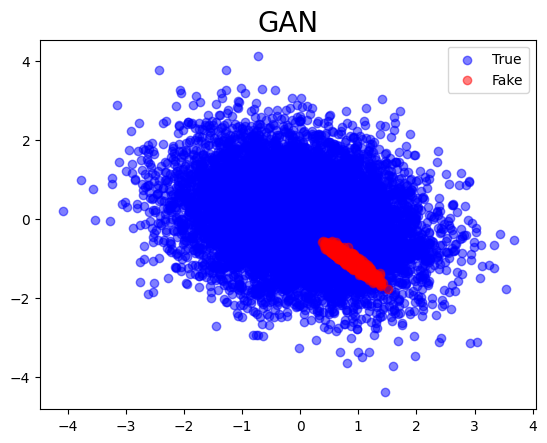

In [4]:
matplotlib.pyplot.title("GAN",fontsize=20)
x = X[:, 0]
y = X[:, 1]
matplotlib.pyplot.scatter(x, y,color='blue',alpha=0.5,label="True")
x = fake_merge[0][:, 0]
y = fake_merge[0][:, 1]
matplotlib.pyplot.scatter(x, y,color='red',alpha=0.5,label="Fake")
matplotlib.pyplot.legend()

# matplotlib.pyplot.title("GAN",fontsize=20)
# x = X[:, 0]
# y = X[:, 1]
# matplotlib.pyplot.scatter(x, y,color='blue', alpha=0.1,s=3)
# x = fake_merge[0][:, 0]
# y = fake_merge[0][:, 1]
# matplotlib.pyplot.scatter(x, y,color='red',marker="x",s=100)
# matplotlib.pyplot.xlim((-3,3))
# matplotlib.pyplot.ylim((-3,3))


## Nash equilibrium convergence until iteration 2500

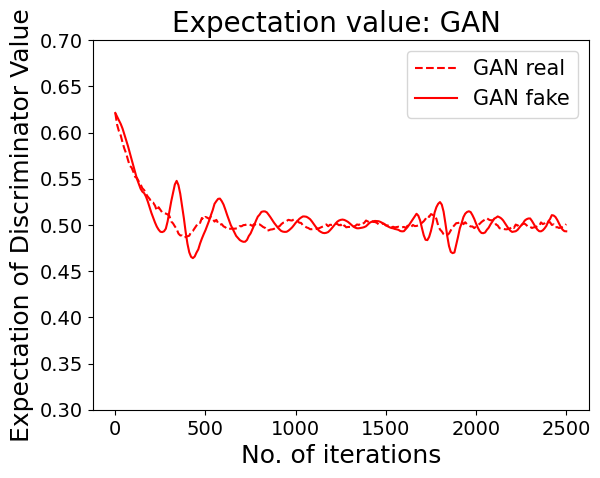

In [5]:
matplotlib.pyplot.title("Expectation value: GAN ",fontsize=20)
matplotlib.pyplot.plot(np.multiply(range(251),10)+1,Dis[:251],label="GAN real",color='red',linestyle='--')
matplotlib.pyplot.plot(np.multiply(range(251),10)+1,Gen[:251],label="GAN fake",color='red',linestyle='-')
matplotlib.pyplot.xlabel('No. of iterations',fontsize=18)
matplotlib.pyplot.ylabel('Expectation of Discriminator Value', fontsize=18)
matplotlib.pyplot.ylim((0.3,0.7))
matplotlib.pyplot.legend(fontsize="15")
matplotlib.pyplot.xticks(fontsize=14)
matplotlib.pyplot.yticks(fontsize=14)
matplotlib.pyplot.show()






## Nash equilibrium convergence (long time)

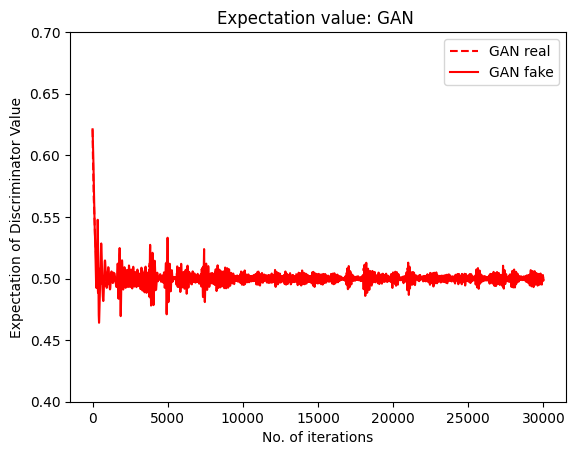

In [8]:
# matplotlib.pyplot.title("Expectation value: GAN ",fontsize=15)
# matplotlib.pyplot.plot(np.multiply(range(3001),10)+1,Dis,label="GAN real",color='red',linestyle='--')
# matplotlib.pyplot.plot(np.multiply(range(3001),10)+1,Gen,label="GAN fake",color='red',linestyle='-')
# matplotlib.pyplot.xlabel('No. of iterations',fontsize=15)
# matplotlib.pyplot.ylabel('Expectation of Discriminator Value',fontsize=15)
# matplotlib.pyplot.ylim((0.3,0.7))
# matplotlib.pyplot.legend()
# matplotlib.pyplot.legend(fontsize="15")

# matplotlib.pyplot.xticks(fontsize=14)
# matplotlib.pyplot.yticks(fontsize=14)
# matplotlib.pyplot.show()


matplotlib.pyplot.title("Expectation value: GAN ")
matplotlib.pyplot.plot(np.multiply(range(3001),10)+1,Dis,label="GAN real",color='red',linestyle='--')
matplotlib.pyplot.plot(np.multiply(range(3001),10)+1,Gen,label="GAN fake",color='red',linestyle='-')
matplotlib.pyplot.xlabel('No. of iterations')
matplotlib.pyplot.ylabel('Expectation of Discriminator Value')
matplotlib.pyplot.ylim((0.4, 0.7))
matplotlib.pyplot.legend()
matplotlib.pyplot.show()


## Evolution of coverage

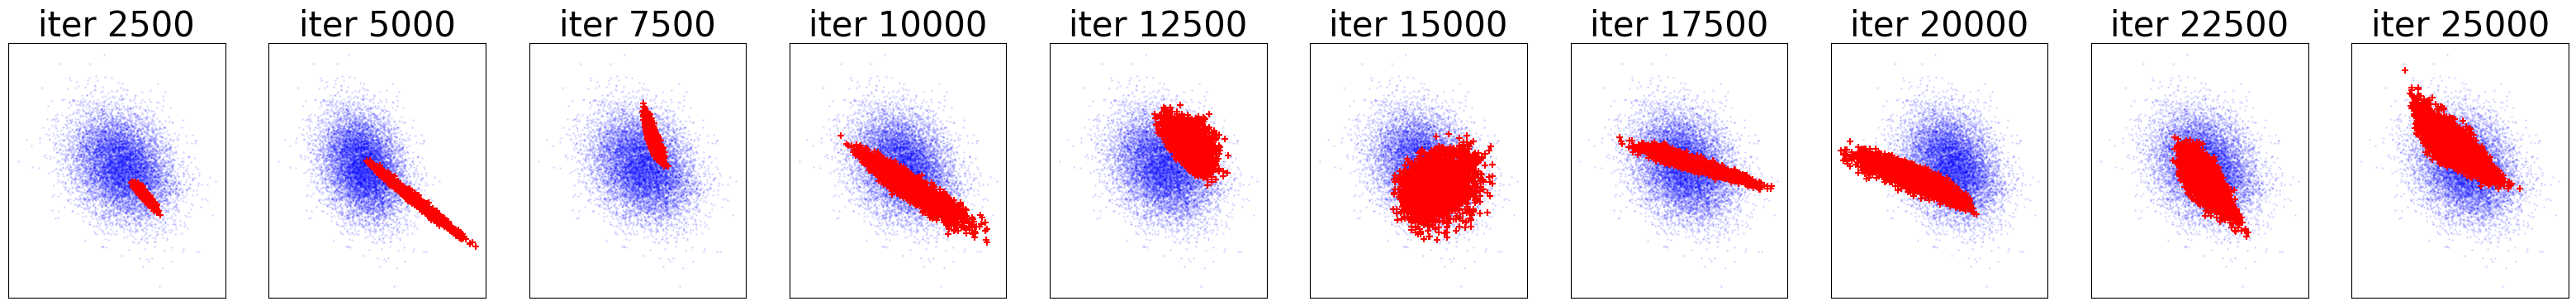

In [7]:
font_s=30
r_size=1
f_size=30
r_alpha=0.1
x = X[:, 0]
y = X[:, 1]
fig, (axs) = matplotlib.pyplot.subplots(1, 10,figsize=(40,4))
i=2500
for j in range(10):
  axs[j].scatter(x, y,color='blue',alpha=r_alpha,s=r_size)
  axs[j].scatter(fake_merge[j][:, 0],fake_merge[j][:, 1],color="red", marker="+",s=f_size)
  axs[j].set_title("iter %s"%i,fontsize=font_s)
  axs[j].set_xticks([])
  axs[j].set_yticks([])
  i+=2500
